In [3]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [4]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3, dirichlet, neumann

In [5]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

In [6]:
def f1(x,y):
    return 1

def f2(x,y):
    return math.sin(2*math.pi*x) + math.sin(math.pi*y)

In [7]:
#Basis functions
#inutile car on calcule les termes de la matrice de masse à la main
def eta1(x,y):
    return 1 - x - y

def eta2(x,y):
    return x

def eta3(x,y):
    return y

solution [0. 0. 0. ... 0. 0. 0.]


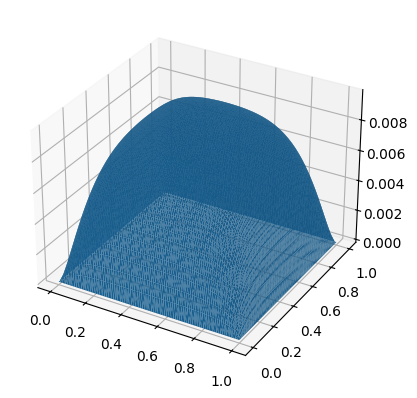

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [8]:
##################### Assembly B ################

n = 100
coordinates, elements3, dirichlet, neumann = maillage(n)
B = np.zeros(n*n)
c_0 = 100 # on déterminine comme on veut, il est fixé au début du pb


for e in elements3:
    
    mat = [[coordinates[e[1]][0] - coordinates[e[0]][0], coordinates[e[2]][0] - coordinates[e[0]][0]],[coordinates[e[1]][1] - coordinates[e[1]][1], coordinates[e[2]][1] - coordinates[e[0]][1]]]
    alpha = np.linalg.det(mat)

    x_g = (coordinates[e[0]][0] + coordinates[e[1]][0] + coordinates[e[2]][0])/3
    y_g = (coordinates[e[0]][1] + coordinates[e[1]][1] + coordinates[e[2]][1])/3
    
    b_local = (alpha/6) * f1(x_g, y_g)
    
    for k in range(3):
       B[e[k]] += b_local

#print(B)


##################### Assembly A ################

A = scps.csr_matrix((n*n,n*n)).toarray() #on construit A en tant que matrice v
M_base = [[1/12, 1/24, 1/24],
     [1/24, 1/12, 1/24],
     [1/24, 1/24, 1/12]] #calculée à la main



for e in elements3:
    
    # Assembly A_local
    # Compute alpha and T
    
    mat = [[coordinates[e[1]][0] - coordinates[e[0]][0], coordinates[e[2]][0] - coordinates[e[0]][0]],
            [coordinates[e[1]][1] - coordinates[e[0]][1], coordinates[e[2]][1] - coordinates[e[0]][1]]] #J_t dans le sujet
    alpha = np.linalg.det(mat) # det de J_t
    T = alpha / 2

    M = c_0 * alpha * np.array(M_base) #mass matrix
    A_local = np.zeros((3, 3))
    #Calculer M à la place de A_local et remplacer le gradient par les intégrales des fonctions de base
    for i in range(3):
        
        gradni = [(coordinates[e[(i + 1) % 3]][1] - coordinates[e[(i + 2) % 3]][1]) / alpha, 
                  (coordinates[e[(i + 2) % 3]][0] - coordinates[e[(i + 1) % 3]][0]) / alpha]
        # print("gradni", gradni)
        
        for j in range(3):
            gradnj = [(coordinates[e[(j + 1) % 3]][1] - coordinates[e[(j + 2) % 3]][1]) / alpha, 
                      (coordinates[e[(j + 2) % 3]][0] - coordinates[e[(j + 1) % 3]][0]) / alpha]
            # print("gradnj", gradnj)
            
            A_local[i][j] = T * (np.dot(gradnj, gradni))
            
    for i in range(3):
        for j in range(3):
            A[e[i]][e[j]] += A_local[i][j] + M[i][j] #on assemble la matrice de rigidité
                   
    
#application des conditions de Dirichlet
for d in dirichlet:
    A[d, :] = 0
    A[d,d] = 1
    B[d] = 0

solution = ssl.spsolve(scps.csr_matrix(A), B)
print("solution", solution)
show(coordinates, solution)
print 


**Partie I bis : maillage carré**

In [44]:
def maillage_quad(n):
# 
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des quadrilatères.
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#   
# Entrees :
# n : nombre de points par cote du carre => Npts points de discretisation au
# total
#  
# Sorties :es :es :
# coordinates : matrice a deux colonnes. Chaque ligne contient les
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront
# identifies a l'indice de la ligne correspondante dans la matricericerice
# coordinates.
# elements4 : matrice a quatre colonnes. Chaque ligne contient les indices 
# des sommets d'un element quadrilatère, dans le sens antihoraire 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h = 1 / (n - 1)
    npoin = n * n
    nelem = (n - 1) * (n - 1)
    coordinates = np.zeros((npoin, 2))
    elements4 = np.zeros((nelem, 4), dtype=int)
    neumann = []
    dirichlet = np.zeros((4 * n , 1), dtype=int)

    # Coordonnees et connectivites :
    p = -1
    for j in range(n):
        for i in range(n):
            p += 1
            coordinates[p, 0] = i * h
            coordinates[p, 1] = j * h
            if i < n - 1 and j < n - 1:
                e = j * (n - 1) + i
                p1 = j * n + i
                p2 = p1 + 1
                p3 = p1 + n
                p4 = p3 + 1
                elements4[e, :] = [p1, p2, p4, p3]

    # Liste des sommets de la frontiere de Dirichlet:
    p = -1
    for i in range(n):  # Bas
        p += 1
        dirichlet[p, 0] = i
    for i in range(n - 1, n * n, n):  # Droite
        p += 1
        dirichlet[p, 0] = i
    for i in range(n * n - 1, n * n - n - 1, -1):  # Haut
        p += 1
        dirichlet[p, 0] = i
    for i in range(n * (n - 1), -1, -n):  # Gauche
        p += 1
        dirichlet[p, 0] = i

    return coordinates, elements4, dirichlet, neumann


In [45]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements4, coordinates.
#
# Entrees:
# elements4 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################

    n = int(np.sqrt(len(coordinates))) - 1
    X = coordinates[:, 0].reshape(n + 1, n + 1)
    Y = coordinates[:, 1].reshape(n + 1, n + 1)
    Z = u.reshape(n + 1, n + 1)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k')
    
    plt.show()

In [46]:
def f1(x,y):
    return 1

def f2(x,y):
    return math.sin(2*math.pi*x) + math.sin(math.pi*y)

[[   0]
 [   1]
 [   2]
 [   3]
 [   4]
 [   5]
 [   6]
 [   7]
 [   8]
 [   9]
 [  10]
 [  11]
 [  12]
 [  13]
 [  14]
 [  15]
 [  16]
 [  17]
 [  18]
 [  19]
 [  20]
 [  21]
 [  22]
 [  23]
 [  24]
 [  25]
 [  26]
 [  27]
 [  28]
 [  29]
 [  30]
 [  31]
 [  32]
 [  33]
 [  34]
 [  35]
 [  36]
 [  37]
 [  38]
 [  39]
 [  40]
 [  41]
 [  42]
 [  43]
 [  44]
 [  45]
 [  46]
 [  47]
 [  48]
 [  49]
 [  50]
 [  51]
 [  52]
 [  53]
 [  54]
 [  55]
 [  56]
 [  57]
 [  58]
 [  59]
 [  60]
 [  61]
 [  62]
 [  63]
 [  64]
 [  65]
 [  66]
 [  67]
 [  68]
 [  69]
 [  70]
 [  71]
 [  72]
 [  73]
 [  74]
 [  75]
 [  76]
 [  77]
 [  78]
 [  79]
 [  80]
 [  81]
 [  82]
 [  83]
 [  84]
 [  85]
 [  86]
 [  87]
 [  88]
 [  89]
 [  90]
 [  91]
 [  92]
 [  93]
 [  94]
 [  95]
 [  96]
 [  97]
 [  98]
 [  99]
 [  99]
 [ 199]
 [ 299]
 [ 399]
 [ 499]
 [ 599]
 [ 699]
 [ 799]
 [ 899]
 [ 999]
 [1099]
 [1199]
 [1299]
 [1399]
 [1499]
 [1599]
 [1699]
 [1799]
 [1899]
 [1999]
 [2099]
 [2199]
 [2299]
 [2399]
 [2499]


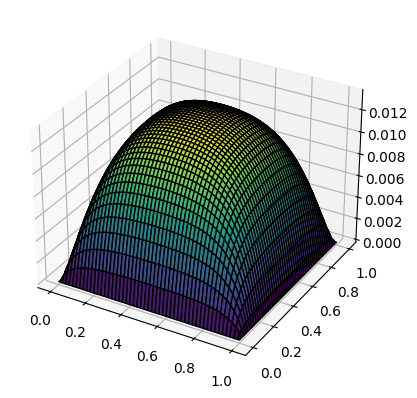

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [ ]:
##################### Assembly B ################

n = 100
coordinates, elements4, dirichlet, neumann = maillage_quad(n)

B = np.zeros(n * n)
c_0 = 100  # on détermine c_0 comme on veut, il est fixé au début du pb et influe sur la solution finale

for e in elements4:
    mat = [[coordinates[e[1]][0] - coordinates[e[0]][0], coordinates[e[3]][0] - coordinates[e[0]][0]],
           [coordinates[e[1]][1] - coordinates[e[0]][1], coordinates[e[3]][1] - coordinates[e[0]][1]]]
    alpha = np.linalg.det(mat)

    x_g = (coordinates[e[0]][0] + coordinates[e[1]][0] + coordinates[e[2]][0] + coordinates[e[3]][0]) / 4
    y_g = (coordinates[e[0]][1] + coordinates[e[1]][1] + coordinates[e[2]][1] + coordinates[e[3]][1]) / 4

    b_local = (alpha / 4) * f1(x_g, y_g)

    for k in range(4):
        B[e[k]] += b_local

#print(B)


##################### Assembly A ################

A = scps.csr_matrix((n*n,n*n)).toarray() #on construit A en tant que matrice v

M_base = [[19/180, 2/45, 1/72, 2/45],
          [2/45, 19/180, 1/90, 1/72],
          [1/72, 1/90, 19/180, 1/90],
          [2/45, 1/72, 1/90, 19/180]] #calculée à la main

# Compute alpha and T
    
mat = [[coordinates[e[1]][0] - coordinates[e[0]][0], coordinates[e[3]][0] - coordinates[e[0]][0]],
        [coordinates[e[1]][1] - coordinates[e[0]][1], coordinates[e[3]][1] - coordinates[e[0]][1]]] #J_t dans le sujet
alpha = np.linalg.det(mat) # det de J_t
T = alpha / 2

M = c_0 * alpha * np.array(M_base) #mass matrix

for e in elements4:
    
    # Assembly A_local
    # Compute alpha and T
    
    mat = [[coordinates[e[1]][0] - coordinates[e[0]][0], coordinates[e[3]][0] - coordinates[e[0]][0]],
            [coordinates[e[1]][1] - coordinates[e[0]][1], coordinates[e[3]][1] - coordinates[e[0]][1]]] #J_t dans le sujet
    alpha = np.linalg.det(mat) # det de J_t
    T = alpha / 2

    M = c_0 * alpha * np.array(M_base) #mass matrix
    A_local = np.zeros((4, 4))
    #Calculer M à la place de A_local et remplacer le gradient par les intégrales des fonctions de base
    for i in range(4):
        
        gradni = [(coordinates[e[(i + 1) % 4]][1] - coordinates[e[(i + 2) % 4]][1]) / alpha, 
                  (coordinates[e[(i + 2) % 4]][0] - coordinates[e[(i + 1) % 4]][0]) / alpha]
        # print("gradni", gradni)
        
        for j in range(4):
            gradnj = [(coordinates[e[(j + 1) % 4]][1] - coordinates[e[(j + 2) % 4]][1]) / alpha, 
                      (coordinates[e[(j + 2) % 4]][0] - coordinates[e[(j + 1) % 4]][0]) / alpha]
            # print("gradnj", gradnj)
            
            A_local[i][j] = T * (np.dot(gradnj, gradni))
            
    for i in range(4):
        for j in range(4):
            A[e[i]][e[j]] += A_local[i][j] + M[i][j] #on assemble la matrice de rigidité
                   

# Application des conditions de Dirichlet
for d in dirichlet:
    A[d, :] = 0
    A[d, d] = 1
    B[d] = 0

solution = ssl.spsolve(scps.csr_matrix(A), B)
print("solution", solution)
show(coordinates, solution)
print 



**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [13]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

**Compléments  :  un nouveau terme dans l'EDP**